In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pycountry # country locales for filtering non-countries

!pip install pandas-bokeh 
import pandas_bokeh
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.models import ColumnDataSource
pandas_bokeh.output_notebook()


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

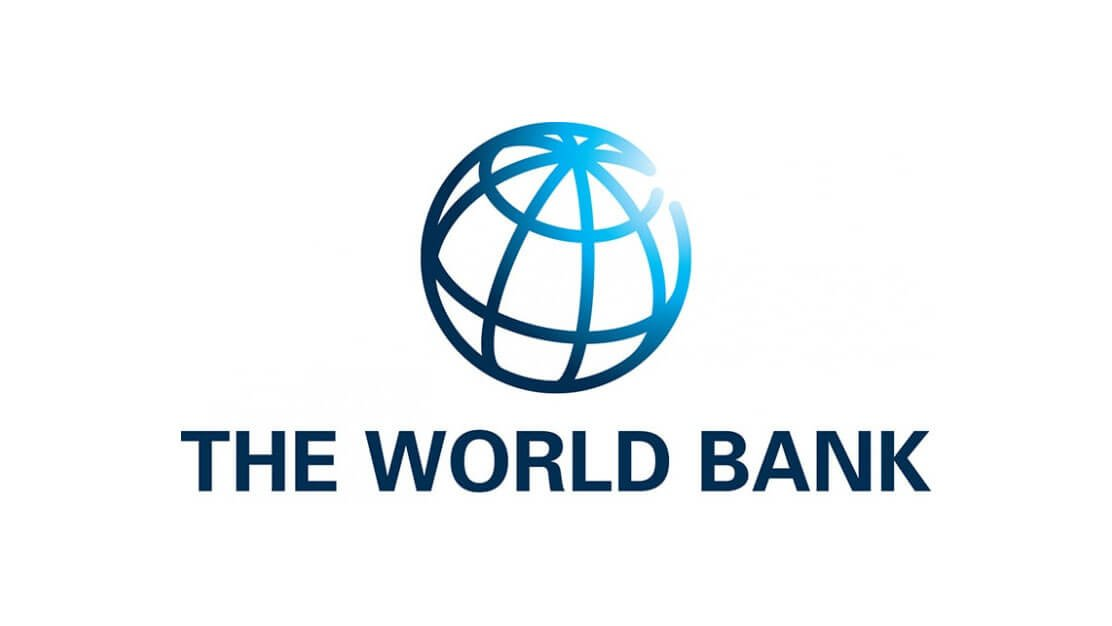

The World Bank is an international financial institution that provides loans and grants to the governments of low- and middle-income countries for the purpose of pursuing capital projects. <cyte>https://en.wikipedia.org/wiki/World_Bank</cyte>

The compiled this dataset and have several others available at https://data.worldbank.org/

# Table of Contents
* [Analyzing the Data](#analyze)
* [Data Preperation](#prep)
* [Visualization](#viz)
* [Modeling [TODO]](#model)

<a id="analyze"></a>
# Analyzing the Data

In [ ]:
df = pd.read_csv('/kaggle/input/gdp-annual-growth-for-each-country-1960-2020/GDP_annual_growth.csv')

display(df.head(3))
display(df.describe())
#display(df.info)

The top 10 GDPs of 2019 are for non-countries so I'm filtering to only include countries going forward using the library pycountry.

In [ ]:
display(df[['Country Name', 'Country Code', '2019']].sort_values('2019', ascending=False).head(10))

countries_code = [x.alpha_3 for x in pycountry.countries]
result = df['Country Code'].isin(countries_code)
n = []
for i in range(len(result)):
    if(result[i] == False):
        n.append(i)

print(f'\nNumber of Countries: {len(n)}')
df=df.drop(n, axis=0)

print('\nNew top 10 of 2019:')
df[['Country Name', 'Country Code', '2019']].sort_values('2019', ascending=False).head(10)

Looks like 'Indicator Code', 'Indicator Name', the year '2020' and 'Unnamed: 65' don't contain anything useful so I'm removing those. 

I'm also not interested in using 'Country Code' so I'll drop that and just use Country Name going forward

In [ ]:
display(df[['Unnamed: 65', 'Indicator Code','Indicator Name', '2020']].groupby('Indicator Name').count())
del df['Unnamed: 65']
del df['Indicator Code']
del df['Indicator Name']
del df['Country Code']
del df['2020']

No duplicate countries, nice :)

In [ ]:
df[df['Country Name'].duplicated()]

<a id="prep"></a>
# Data Preparation


I prefer working with data that has date as the index. This can be accomplished with pd.melt() then df.pivot()

In [ ]:
melted_df = pd.melt(df, id_vars=["Country Name"], var_name="Year", value_name="GDP")
display(melted_df.head())

pivoted_df = melted_df.pivot(index='Year', columns='Country Name', values='GDP')
display(pivoted_df.head())

Getting a list of the top/bottom 10 countries based on 2019 GDP for use later.

In [ ]:
top_10_countries = pivoted_df.loc['2019':].T.dropna().sort_values(by='2019', ascending=False).head(10).index.tolist()
bottom_10_countries = pivoted_df.loc['2019':].T.dropna().sort_values(by='2019').head(10).index.tolist()
print("Top 10:",top_10_countries)
print()
print("Bottom 10:",bottom_10_countries)

Converting Year to datetime:

In [ ]:
pivoted_df = pivoted_df.reset_index()
pivoted_df['Year'] = pd.to_datetime(pivoted_df['Year'])
pivoted_df = pivoted_df.set_index('Year')
pivoted_df.tail()

In [ ]:
dates_2010_2020 = pivoted_df.index.to_series().between('2010-01-01', '2020-01-01')
#dates_1960_2020 = df.index.to_series().between('1960-01-01', '2020-01-01')

past_10_years = pivoted_df[dates_2010_2020]

past_10_years[top_10_countries].head()

<a id="viz"></a>
# Visualization

In [ ]:
temp = df[df['Country Name'].isin([
     'United States',
     'China',
     'Japan',
     'Germany',
     'India',
     'United Kingdom',
     'France',
     'Italy',
     'Brazil',
     'Canada'])].fillna(0)
temp.plot_bokeh.pie(
    x="Country Name",
    y="1970",
    title="Top 10 Countries by GDP in 1970",
    )
temp.plot_bokeh.pie(
    x="Country Name",
    y="1995",
    title="Top 10 Countries by GDP in 1995",
    )
temp.plot_bokeh.pie(
    x="Country Name",
    y="2019",
    title="Top 10 Countries by GDP in 2019",
    )

In [ ]:
temp = pivoted_df[top_10_countries].reset_index().fillna('')
temp.plot_bokeh.area(
    x="Year",
    stacked=True,
    legend="top_left",
    #colormap=["brown", "orange", "black", "grey", "blue", "green"],
    title="GDP Growth of the top 10 Countries",
    ylabel="US$",
    ylim=(0, 6e+13))

In [ ]:
temp = pivoted_df[['United Kingdom','France']].fillna('')

data_table = DataTable(
    columns=[TableColumn(field=Ci, title=Ci) for Ci in temp.columns],
    source=ColumnDataSource(temp),
    height=500,
    width=300
)

p_line = temp.plot_bokeh.line(
    title="GDP by Top 10 Countries",
    show_figure=False,
    rangetool=True
)

pandas_bokeh.plot_grid([[p_line,data_table]], plot_width=500, plot_height=350)  

In [ ]:
temp = pivoted_df[bottom_10_countries].fillna(0)

p_line = temp.plot_bokeh.line(
    title="GDP by Bottom 10 Countries",
    rangetool=True
)

In [ ]:
pct_change = pivoted_df.pct_change()
dates_1970_2020 = pct_change.index.to_series().between('1970-01-01', '2020-01-01')
pct_change = pct_change[dates_1970_2020].multiply(100)
display(pct_change.tail())

cumulative_pct_change = pct_change.dropna(axis='columns').cumsum().tail(1).reset_index().drop(['Year'], axis=1).T.sort_values(by=0, ascending=False).rename(columns = {0:"Cumulative % Change in GDP"})
cumulative_pct_change

In [ ]:
dates_1970_2020 = pct_change.index.to_series().between('1970-01-01', '2020-01-01')
temp = pct_change[dates_1970_2020].dropna(axis='columns')

top_5 = cumulative_pct_change.index.tolist()[:5]
top_5.append('United States')

temp = temp[top_5]

p_line = temp.plot_bokeh.line(
    title="% Change in GDP - Top 5 Countries + United States",
    rangetool=True
)

In [ ]:
dates_1970_2020 = pct_change.index.to_series().between('1970-01-01', '2020-01-01')
temp = pct_change[dates_1970_2020].dropna(axis='columns')

bottom_5 = cumulative_pct_change.index.tolist()[-5:]
bottom_5.append('United States')

temp = temp[bottom_5]

p_line = temp.plot_bokeh.line(
    title="% Change in GDP - Bottom 5 Countries + United States",
    rangetool=True
)

In [ ]:
pct_change_world = pct_change.mean(axis=1)
pct_change_world = pd.DataFrame(pct_change_world, columns=['Average GDP Change'])
display(pct_change_world.head())

p_line = pct_change_world.plot_bokeh.line(
    title="Average % Change in GDP for All Countries",
    rangetool=True
)

<a id="model"></a>
# TODO - Forcasting GDP